In [1]:
import pandas as pd
from datetime import date
import numpy as np
from collections import OrderedDict
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
import matplotlib
from decimal import Decimal

In [2]:
# from - http://rhodesmill.org/brandon/2014/pandas-payroll/
def c(value):
    "Convert `value` to Decimal cents."
    one_cent = Decimal('0.01')
    return Decimal(value).quantize(one_cent)

http://www.decisionaide.com/mpcalculators/extrapaymentscalculator/ExtraPayments1Amort.asp

In [3]:
%matplotlib inline

In [4]:
def amortize(start_date, orig_bal, interest_rate=.04, years=30, additional_payment=0):

    annual_payments=12
    
    # Payment stays constant based on the original terms of the loan
    pmt = np.pmt(interest_rate/annual_payments, years*annual_payments, orig_bal)
    
    # Convert number to unsigned Decimal
    pmt = Decimal(abs(pmt))
    
    # initialize the loop variables to keep track of the periods 
    # and running begin and end balances as decimals
    p = 1
    beg_balance = Decimal(orig_bal)
    end_balance = Decimal(orig_bal)
    
    while end_balance > 0:
        
        # Recalculate the interest based on the current balance
        interest = Decimal(interest_rate/annual_payments) * beg_balance
        
        # Check to see if we are paying it off early and limit 
        # the final payment to no more than the balance due
        # TODO: make this smarter with respect to the additional payment
        if pmt > beg_balance:
            pmt = beg_balance + interest
            additional_payment = 0
        principal = pmt - interest
        end_balance = beg_balance - (principal + additional_payment)

        yield OrderedDict([('Month',start_date),
                           ('Period', p),
                           ('Begin Balance', c(beg_balance)),
                           ('Payment', c(pmt)),
                           ('Principal', c(principal)),
                           ('Interest', c(interest)),
                           ('Additional_Payment', c(additional_payment)),
                           ('End Balance', c(end_balance))])
        
        # Increment the counter, balance and date
        p += 1
        start_date += relativedelta(months=1)
        beg_balance = end_balance

In [5]:
# Test a call to the function

In [6]:
a = amortize(start_date=date(2016,1,1),
                        orig_bal=200000,
                        interest_rate=.045,
                        additional_payment=50)

In [7]:
max([el['Month'] for el in a])

datetime.date(2043, 3, 1)

In [8]:
# Create a dataframe

In [9]:
sched = pd.DataFrame(amortize(start_date=date(2016,1,1), orig_bal=700000, 
                              interest_rate=.04, additional_payment=200))
sched = sched[["Period", "Month", "Begin Balance", "Payment", "Interest", 
               "Principal", "Additional_Payment", "End Balance"]]
sched.head(5)

,Period,Month,Begin Balance,Payment,Interest,Principal,Additional_Payment,End Balance
0,1,2016-01-01,700000.00,3341.91,2333.33,1008.57,200.00,698791.43
1,2,2016-02-01,698791.43,3341.91,2329.30,1012.60,200.00,697578.82
2,3,2016-03-01,697578.82,3341.91,2325.26,1016.64,200.00,696362.18
3,4,2016-04-01,696362.18,3341.91,2321.21,1020.70,200.00,695141.48
4,5,2016-05-01,695141.48,3341.91,2317.14,1024.77,200.00,693916.71


In [10]:
sched.tail()

,Period,Month,Begin Balance,Payment,Interest,Principal,Additional_Payment,End Balance
319,320,2042-08-01,14415.35,3341.91,48.05,3293.86,200.00,10921.49
320,321,2042-09-01,10921.49,3341.91,36.40,3305.50,200.00,7415.99
321,322,2042-10-01,7415.99,3341.91,24.72,3317.19,200.00,3898.80
322,323,2042-11-01,3898.80,3341.91,13.00,3328.91,200.00,369.89
323,324,2042-12-01,369.89,371.12,1.23,369.89,0.00,0.00


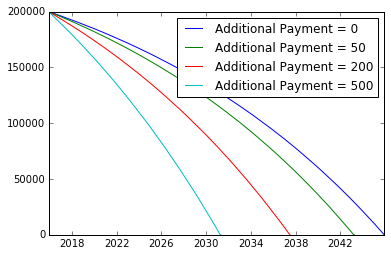

In [11]:
additional_payments = [0, 50, 200, 500]
results = list(map(lambda x: list(amortize(start_date=date(2016,1,1),
                                           orig_bal=200000,
                                           additional_payment=x)),
                   additional_payments))
fig, ax = plt.subplots(1, 1)

for result, payment in zip(results, additional_payments):
    ax.plot([x['Month'] for x in result], [x['End Balance'] for x in result], label='Additional Payment = ' + str(payment))

ax.legend();